In [1]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import repfr_crps as rcrp

In [2]:
evs = []
data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR1']
for subject, df in data.groupby('subject'):
    for session in pd.unique(df['session']):
        r = cml.CMLReader(subject=subject, experiment='RepFR1', session=session)
        temp = r.load('task_events')
        evs.append(temp)
evs = pd.concat(evs)
evs = evs[evs.list != 0]
evs.subject.unique()

array(['R1204T', 'R1501J', 'R1514E', 'R1516E', 'R1528E', 'R1531T',
       'R1534D', 'R1547D', 'R1556J', 'R1564J', 'R1566D', 'R1568E',
       'R1579T', 'R1582E', 'R1584J', 'R1586T', 'R1587J', 'R1589T',
       'R1590T', 'R1594E', 'R1596T'], dtype=object)

In [132]:
evs = []
data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
for subject, df in data.groupby('subject'):
    for session in pd.unique(df['session']):
        r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
        temp = r.load('all_events')
        evs.append(temp)
evs = pd.concat(evs)
evs = evs[evs.list != 0]

In [3]:
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']

In [4]:
def abs_min_split(items):
    mini = []
    mini.append(items[0])
    for item in items[1:]:
        if abs(item) < abs(mini[0]):
            mini = []
            mini.append(item)
        elif abs(item) == abs(mini[0]):
            mini.append(item)
    mini = set(mini)
    mini = list(mini)
    return mini

def abs_min_pos(items):
    mini = []
    mini.append(items.pop(0))
    for item in items:
        if abs(item) < abs(mini[0]):
            mini = []
            mini.append(item)
        elif abs(item) == abs(mini[0]):
            mini.append(item)
    if len(mini) > 1:
        mini = [abs(mini[0])]
    return mini

In [5]:
def min_pos_lags(df):
    items = df['pos_lags'].to_list()
    mini = []
    mini.append(items.pop(0))
    for item in items:
        if abs(item) < abs(mini[0]):
            mini = []
            mini.append(item)
        elif abs(item) == abs(mini[0]):
            mini.append(item)
    if len(mini) > 1:
        mini = [abs(mini[0])]
    mini = mini[0]
    return mini

In [6]:
def min_crp(evs, num_lags, list_length, halfornah ='nah'): 
    pos_lags = np.zeros((2*list_length-1))
    act_lags = np.zeros((2*list_length-1))
    for l, df in evs.groupby('list'):
        rec_df = df[df.type == 'REC_WORD']
        enc_df = df[df.type == 'WORD']
        item_num_enc = enc_df.item_num.to_numpy()
        item_num_rec = rec_df.item_num.to_numpy()
        used_positions = np.zeros(list_length)
        serialpos = rec_df.act_serialpos.to_numpy()
        
        crp = pd.DataFrame(columns=['lag', 'prob'])
        crp['lag'] = pd.Series(range(-list_length +1, list_length))
        for i in range(len(serialpos)-1):
            temp_lags = []
            try:
                for j, previous in enumerate(serialpos[i]):
                    used_positions[previous] +=1
                    for k, current in enumerate(serialpos[i+1]):
                        if current - previous != 0:
                            temp_lags.append(current - previous) 
    #             MAKE SURE ALL OF THIS IS OUTSIDE OF FOR LOOPS
                if halfornah == 'nah':
                    lag = abs_min_pos(temp_lags)[0]

                    act_lags[lag+list_length-1]+=1
    #     Use this for half and half crp
                else:
                    lags = abs_min_split(temp_lags)
                    if len(lags) > 1:           
                        for lag in lags:
                            act_lags[lag+list_length-1] += 0.5
                    else:
                        act_lags[lags[0]+list_length-1]+=1
                open_pos, = np.where(used_positions==0)
                item_num_enc = enc_df.item_num.to_numpy()
                item_num_rec = rec_df.item_num.to_numpy()
                all_pos_lags = pd.DataFrame(pd.Series(np.arange(-list_length+1, list_length), name = 'pos_lags'))
                all_pos_lags.set_index('pos_lags', inplace = True)
                all_pos_lags['item_num'] = pd.Series(np.nan, index = all_pos_lags.index)
                all_pos_lags.drop(0, 0, inplace = True)
                for spos, pres in enumerate(item_num_enc):
                    if spos in open_pos:
                        all_pos_lag = spos - serialpos[i]
                        all_pos_lags.at[all_pos_lag] = pres
                all_pos_lags.dropna(inplace=True)
                all_pos_lags = all_pos_lags.reset_index().groupby('item_num').apply(lambda x: min_pos_lags(x)) + list_length -1
                pos_lags[all_pos_lags] +=1
            except Exception as e:
                continue
    crp['prob'] = np.divide(act_lags, pos_lags)
    crp = crp[crp['lag'] >= -num_lags]
    crp = crp[crp['lag'] <= num_lags]

    return crp

In [9]:
sub_crps = []
min_crps = []
num_lags = 8
for i, beh in lol(evs.groupby('subject')):
    sess_crps = []
    for j, df in beh.groupby('session'):
        df = rcrp.get_act_spos(df)
        sess_crp = rcrp.min_crp(df, num_lags = num_lags, list_length = 27, halfornah = 'yah')
        sess_crps.append(sess_crp)
    sub_crp = pd.concat(sess_crps).groupby('lag').mean()
    min_crps.append(sub_crp)
min_crps = pd.concat(min_crps)


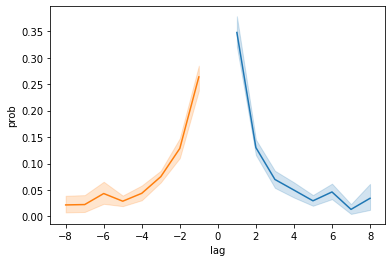

In [6]:
min_crps.reset_index(inplace=True)
sns.lineplot(data = min_crps[min_crps.lag > 0], x = 'lag', y = 'prob')
sns.lineplot(data = min_crps[min_crps.lag < 0], x = 'lag', y = 'prob')

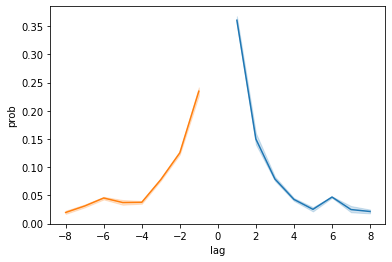

In [57]:
min_crps.reset_index(inplace=True)
sns.lineplot(data = min_crps[min_crps.lag > 0], x = 'lag', y = 'prob')
sns.lineplot(data = min_crps[min_crps.lag < 0], x = 'lag', y = 'prob')